In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time

import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat,loadmat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())



cuda:2


In [2]:
# def true_1D_1(x): #True function for 1D_1 dy2/dx2 + dy/dx - 6y = 0; BC1: y(0)=2; BC2: dy/dx at (x=0) = -1;
#     y = np.exp(-4.0*x) + np.exp(3.0*x)
#     return y

import websocket
import threading
# import numpy as np
import base64
import uuid
import json
# import time

run_uuid = "1e8254d2-dda0-402c-87d2-c4bcad726a97" #Random fixed https://www.uuidgenerator.net/version4
client_uuid = uuid_v4 = uuid.uuid4()

def get_random_loss():
    return np.float32(np.random.rand(6,1))

def initialize_message(client_uuid, run_uuid):
    return '{"messageType":"initialize","clientUUID":"' + str(client_uuid) + '","runUUID":"' + str(run_uuid) + '"}'


def update_message(client_uuid, run_uuid, data):
    base64_data = base64.b64encode(data.tobytes())
    return '{"messageType":"update","clientUUID":"' + str(client_uuid) + '","runUUID":"' + str(run_uuid) + '", "data":"' + str(base64_data, "ascii") + '"}'

class WebSocketClient:
    def __init__(self, url):
        self.url = url
        self.response = None
        self.ws = websocket.WebSocketApp(
            url,
            on_message=self.on_message,
            on_open=self.on_open,
            on_error=self.on_error,
            on_close=self.on_close
        )
        self.ws_thread = threading.Thread(target=self.ws.run_forever)
        self.connected = threading.Event()

    def on_message(self, ws, message):
        #print("|", message, "|")
        json_data = json.loads(message)
        self.response = np.frombuffer(base64.b64decode(json_data["data"]), dtype=np.float32)
        
    def on_open(self, ws):
        self.connected.set()

    def on_error(self, ws, error):
        print(f"WebSocket error: {error}")

    def on_close(self, ws, close_status_code, close_msg):
        self.connected.clear()
        print("WebSocket closed")

    def send_message(self, message):
        self.response = None
        self.ws.send(message)

    def start(self):
        self.ws_thread.start()
        self.connected.wait()  # Wait until the connection is open

    def stop(self):
        self.ws.close()
        self.ws_thread.join()
        

In [3]:
level = "high"
label = "1D_SODE_Stan" + level

#MATLAB Van Der Pol Example https://www.mathworks.com/help/matlab/ref/ode89.html
mu = 1
fo_val = 0.0

loss_thresh = 0.005

x = np.linspace(0,10,100).reshape(-1,1)

bc1_x = x[0].reshape(-1,1)
bc1_y1 = np.array([2]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y1_bc1_train = torch.from_numpy(bc1_y1).float().to(device)
    

bc1_x = x[0].reshape(-1,1)
bc1_y2 = np.array([fo_val]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y2_bc1_train = torch.from_numpy(bc1_y2).float().to(device)    


x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)
# y_true = true_1D_1(x_test)
# y_true_norm = np.linalg.norm(y_true,2)

# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1]) 

In [4]:
def colloc_pts(N_f,seed):
    #Collocation Points
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,y)
    x01 = np.array([[0.0, 1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    
    x_coll_train = lb + (ub-lb)*sampling(N_f)
    x_coll_train = np.vstack((x_coll_train, bc1_x.reshape(-1,1))) # append training points to collocation points 

    return x_coll_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears1 = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears1[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears1[i].bias.data) 
        
        self.beta1 = Parameter(torch.ones((50,len(layers)-2)))
        self.beta1.requiresGrad = True
        
        self.linears2 = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears2[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears2[i].bias.data) 
        
        self.beta2 = Parameter(torch.ones((50,len(layers)-2)))
        self.beta2.requiresGrad = True
    
    'forward pass'
    def forward1(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears1[i](a)
            a = self.activation(z) + self.beta1[:,i]*z*self.activation(z)
            
        a = self.linears1[-1](a) 
         
        return a
    
    def forward2(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears2[i](a)
            a = self.activation(z) + self.beta2[:,i]*z*self.activation(z)
            
        a = self.linears2[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward1(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x,y):
                
        loss_bc2 = self.loss_function(self.forward2(x), y)
                
        return loss_bc2
    
    def loss_PDE1(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y1 = self.forward1(g)
        y2 = self.forward2(g)

        y1_x = autograd.grad(y1,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
       
        dy1_dx = y1_x[:,[0]]
        
        f = dy1_dx - y2 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss_PDE2(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y1 = self.forward1(g)
        y2 = self.forward2(g)

        y2_x = autograd.grad(y2,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
       
        dy2_dx = y2_x[:,[0]]
        
        f = dy2_dx - mu*(1-torch.square(y1))*y2 + y1
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss_y1(self,x_bc1,y_bc1,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_f = self.loss_PDE1(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_f
        
        return loss_val
    
    def loss_y2(self,x_bc2,y_bc2,x_coll,f_hat):

        loss_bc2 = self.loss_BC2(x_bc2,y_bc2)
        loss_f = self.loss_PDE2(x_coll,f_hat)
        
        loss_val = loss_bc2 + loss_f
        
        return loss_val
    
    'test neural network'
    
    def test(self):
        y_pred = self.forward1(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        # test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        # test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        test_mse = 0
        test_re = 0
        
        return test_mse, test_re

In [6]:
def train_step(x_coll,f_hat):
    
    def closure1():
        optimizer.zero_grad()
        # loss = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat) 
        # print(loss)
        loss = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat)
        
        cpu_loss = loss.clone().cpu().detach().numpy()

        ws_client.send_message(update_message(client_uuid, run_uuid, cpu_loss))
        while ws_client.response is None:
            pass
        
        loss.copy_(torch.from_numpy(ws_client.response.copy().reshape(loss.shape)))
        # print("recieved", aggregated_loss)
        ws_client.response = None
        loss.backward()

        return loss
    
#     def closure2():
#         optimizer.zero_grad()
#         loss = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat)
#         loss.backward()
        
#         return loss

    # optimizer.step(closure2)
    
    optimizer.step(closure1)
    

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_model(max_iter,rep):
    print(rep) 
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    x_coll = torch.from_numpy(colloc_pts(N_f,0)).float().to(device)
    f_hat = torch.zeros(x_coll.shape[0],1).to(device)
    
    loss_np1 = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat).cpu().detach().numpy()
    loss_np2 = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat).cpu().detach().numpy()
    
    # data_update(loss_np1)
    for i in range(max_iter):
        # x_coll = torch.from_numpy(colloc_pts(N_f,i*11)).float().to(device)
        # f_hat = torch.zeros(x_coll.shape[0],1).to(device)
        train_step(x_coll,f_hat)
        
        loss_np1 = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat).cpu().detach().numpy()
        loss_np2 = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat).cpu().detach().numpy()
            
        # data_update(loss_np1)
        # print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        print(i,"Loss1",loss_np1,"Loss2",loss_np2)
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 1
max_iter = 200

N_f = 1000

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss =[]
    beta_val = []
    
    'Generate Training data'
    torch.manual_seed(reps*36)
     #Total number of collocation points 
    
    
    layers = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    # layers = np.array([1,50,50,50,50,1])
    PINN = Sequentialmodel(layers)
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25, 
                              max_iter = 10, 
                              max_eval = 15, 
                              tolerance_grad = 1e-5, 
                              tolerance_change = 1e-5, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
   

     # Usage
    ws_client = WebSocketClient("ws://128.173.95.177:8087")

    # Start WebSocket communication in a separate thread
    ws_client.start()

    # Send a message and wait for the response
    ws_client.send_message(initialize_message(client_uuid, run_uuid))

    # IMPORTANT: this give you time to start the other script and have 
    # it reach the same starting point. If they don't start together,
    # one training will complete before the other and the other will never
    # finish.
    time.sleep(10)

    train_model(max_iter,reps)

    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)    
    
    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full, "test_re_loss": test_re_full, "Time": elapsed_time, "beta": beta_full, "label": label, "Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-8): 8 x Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-8): 8 x Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Loss1 3.5670803 Loss2 0.25592807
WebSocket error: Connection to remote host was lost.
WebSocket closed


KeyboardInterrupt: 

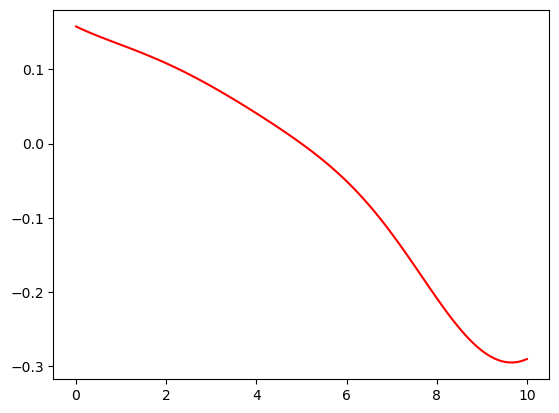

In [ ]:
u_pred = PINN.test()
plt.plot(x,u_pred,'r')
# plt.plot(y_true,'b')

In [ ]:
# data_mat = loadmat('Vanderpol_ODEsolver.mat')
# y = data_mat['y'][:,0]
# t = data_mat['t']

# fig,ax = plt.subplots()
# ax.plot(t,y,'b',linewidth = 2,label = 'Numerical Solver')
# ax.plot(x,u_pred,'r-.',linewidth = 2,label = 'Coupled PINN')
# ax.set_xlabel('Time(s)')
# ax.set_ylabel('Value')
# ax.set_title('van der Pol Oscillator')
# ax.legend(loc = 3)
# plt.savefig('Coupled_PINN_VanderPol.svg',format = 'svg')
# plt.savefig('Coupled_PINN_VanderPol.png',format = 'png')

WebSocket error: Connection to remote host was lost.
WebSocket closed
